# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
5638,10647,55599,Essex,19-03-2020,Hi everyone I am looking to speak to anyone wh...,Extremely Positive
412,4297,49249,Wonderland,16-03-2020,No canned goods at my local grocery store \r\r...,Negative
7232,12583,57535,Wight City Missouri USA.,20-03-2020,Sick of supermarket queues and empty shelves o...,Extremely Negative
6942,12243,57195,South Africa,19-03-2020,Government has published strict regulations to...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x.split()[-1] == 'Positive' else 0)

Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
1,18046
0,15398


**Ответ:** Можем считать, что да - разница незначительная


Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df.isna().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
df = df.fillna('Unknown')

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [ ]:
dct = {}
for txt in train['OriginalTweet']:
  for word in txt.lower().split():
    dct[word] = dct.get(word, 0) + 1


Какой размер словаря получился?

In [ ]:
len(dct)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [ ]:
[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token])[:10]]

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** перед нами предлоги, союзы и прочие служебные части речи, без которых нельзя построить свзяный текст; именно поэтому они встречаются чаще всего. Ну и также тег #coronavirus, поскольку мы и рассматриваем твиты по этому тэгу

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
for stopword in stopwords.words('english'):
  dct.pop(stopword, None)

[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token])[:10]]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** перед нами слова, связанные с обсуждаемой темой - тэги и проблемы от короны, они ожидаемо встречаются часто

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: dct[token])[:20]]

[('https://t.co/1m881cwfuv', 1),
 ('happy..', 1),
 ('https://t.co/z0intks34x', 1),
 ('mnuchinã\x82â\x92s', 1),
 ('brink.', 1),
 ('https://t.co/jmobv8z0u0', 1),
 ("university's", 1),
 ('teaching.)', 1),
 ('@catholicpres', 1),
 ('@catholicuniv', 1),
 ('https://t.co/evqby035wf', 1),
 ('https://t.co/riqrhxxeim', 1),
 ('@@ballardspahrll', 1),
 ('#aca', 1),
 ('easier...take', 1),
 ('ã\x82â\x93necessaryã\x82â\x94', 1),
 ('https://t.co/0fmsmlgepm', 1),
 ('husted:', 1),
 ('irishman', 1),
 ('#happystpatricksday!', 1)]

**Ответ:** слова не по теме, в целом, они редко встречаются => их значимость будет малой для опредления окраски. Можно их просто проигнорировать



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
dct = {}
for txt in train['OriginalTweet']:
  for word in tokenizer.tokenize(txt.lower()):
    dct[word] = dct.get(word, 0) + 1

[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token])[:10]]

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** Теперь символы учитываются как отдельный токен, это позволит объединить токены типа: "ужасно" и "ужасно!". А значит значимость каждого токена будет более точной

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

for puncto in punctuation:
  dct.pop(puncto)

for stopword in stopwords.words('english'):
  dct.pop(stopword, None)

[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token])[:10]]

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** да, \x82 заставляет задуматься о много

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
for code in range(128, 256):
  dct.pop(chr(code), None)

[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token])[:10]]

[('#coronavirus', 8808),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805),
 ('grocery', 3523),
 ('people', 3463),
 ('#covid19', 2589)]

**Ответ:** У нас только слова и хэштеги, значимость оценивается лучше

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [ ]:
[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token]) if top_token[0] == '#'][:10]

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** все они о теме и не отражают окраса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
[(top_token, dct[top_token]) for top_token in sorted(dct, key=lambda token: -dct[token]) if top_token[:12] == 'https://t.co'][:10]

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** очень малое количество вхождений, информация полезной не будет

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()
  tokens = TweetTokenizer().tokenize(text)

  res = []
  for token in tokens:
    if token not in stopwords.words('english') and token not in punctuation and token[:12] != 'https://t.co' and (len(token) != 1 or ord(token) < 128):
      res.append(token)

  return res


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


**Ответ:** В два раза меньше стало слов

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
text = train.iloc[ind]['OriginalTweet']
cv_ind = cv.transform([text])
dk = pd.DataFrame(cv_ind.toarray(), columns=cv.get_feature_names_out()).T
dk = dk[dk[0] > 0]
dk

,0
#coronavirusoutbreak,1
#covid2019,1
@skynews,1
brainless,1
ffs,1
food,1
france,1
lets,1
nice,1
one,1


**Ответ:** важные и неважные слова идут со значением 1, с этим невозможно работать

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_vec.fit(train['OriginalTweet'])


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x79da13f6cfe0>)

In [ ]:
ind = 9023
text = train.iloc[ind]['OriginalTweet']
tfidf_vec_ind = tfidf_vec.transform([text])
dk = pd.DataFrame(tfidf_vec_ind.toarray(), columns=tfidf_vec.get_feature_names_out()).T
dk = dk[dk[0] > 0].sort_values(by=0)
dk

,0
food,0.113289
panic,0.147595
one,0.163067
#covid2019,0.168252
#coronavirusoutbreak,0.225843
show,0.244065
nice,0.254273
ppl,0.255006
lets,0.301211
@skynews,0.310426


**Ответ:** Теперь определение лучше, поскольку brainless встречается редко и явно может рассказать о смысле

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
d = train[train['OriginalTweet'].apply(lambda x: 'cool' in x) & (train['Sentiment'] == 1)]

In [ ]:
text = d.iloc[0]['OriginalTweet']
tfidf_vec_ind = tfidf_vec.transform([text])
dk = pd.DataFrame(tfidf_vec_ind.toarray(), columns=tfidf_vec.get_feature_names_out()).T
dk = dk[dk[0] > 0].sort_values(by=0)
dk

,0
store,0.214403
grocery,0.220961
#covid_19,0.270876
thank,0.355053
said,0.377663
clerks,0.499391
cool,0.560135


**Ответ:** "cool" встречается редко, имеет явно положительное значение. Получается сразу высокая важность

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['Sentiment'], random_state=0, test_size=0.3)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [ ]:
x_train_cv = cv.transform(x_train)
x_train_tid = tfidf_vec.transform(x_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR_cv = LogisticRegression()
LR_cv.fit(x_train_cv, y_train)

LR_tid = LogisticRegression()
LR_tid.fit(x_train_tid, y_train)

LogisticRegression()

In [ ]:
y_predict_cv = LR_cv.predict(cv.transform(x_test))
y_predict_tid = LR_tid.predict(tfidf_vec.transform(x_test))

In [ ]:
print(accuracy_score(y_predict_cv, y_test))
print(accuracy_score(y_predict_tid, y_test))

0.8670520231213873
0.85280047837353


**Ответ:** CV показал результат чуть лучше, в целом, обе лог. регресси справляются хорошо

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
# чуть поменял токенайзер в сравнении с тем, что выше; поскольку тот токенайзер делал fit-transform по 100 лет
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokens_p = TweetTokenizer().tokenize(text.lower())
  tokens = []
  stops = set(stopwords.words('english'))
  pucts = set(punctuation)
  for token in tokens_p:
    if token not in stops and token not in pucts and token[:12] !='https://t.co' and (len(token) != 1 or ord(token) < 128):
      tokens.append(stemmer.stem(token))
  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
x_train_cv_stem = cv.fit_transform(x_train)

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


In [ ]:
tfidf_vec = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
x_train_tfidf_stem = tfidf_vec.fit_transform(x_train)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


**Ответ** размер чувствительно уменьшился

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
LR_cv_stem = LogisticRegression()
LR_tf_stem = LogisticRegression()
LR_cv_stem.fit(x_train_cv_stem, y_train)

LR_tf_stem.fit(x_train_tfidf_stem, y_train)

LogisticRegression()

In [ ]:
y_predict_cv_stem = LR_cv_stem.predict(cv.transform(x_test))
y_predict_tf_stem = LR_cv_stem.predict(tfidf_vec.transform(x_test))
print(accuracy_score(y_predict_cv, y_test))
print(accuracy_score(y_predict_cv_stem, y_test))
print(accuracy_score(y_predict_tid, y_test))
print(accuracy_score(y_predict_tf_stem, y_test))

0.8670520231213873
0.8674506677297189
0.85280047837353
0.8573848913693443


**Ответ:** качество улучшилось, применять есть смысл

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36633 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000 # бинарным поиском
                        ).fit(
                            x_train
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


**Ответ:** Видимо, слово с максимальной частотностью встречается примерно в трети документов (кол-во obj в x_train ~25.000), так что нам необходимо достаточно сильно сузить поиск, чтобы выкинуть лишь одно слово - с макс. частотностью

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            x_train
                            )
print(len(cv_df.vocabulary_))

3687


11 - 3687 токенов, 11 - 3918 токенов :(

  Мы отрезали слова, которые встречаются редко; это ускоряет процесс, но может привести к ошибкам (например, brainless явно вносит негативную окраску, но встречается редко). Возможно, качество чуть-чуть упадет


В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_cv = cv_df.transform(x_train)
x_test_cv = cv_df.transform(x_test)
x_train_cv = sc.fit_transform(x_train_cv.toarray())
x_test_cv = sc.transform(x_test_cv.toarray())


In [ ]:
LR = LogisticRegression()
LR.fit(x_train_cv, y_train)
y_test_cv = LR.predict(x_test_cv)

print(accuracy_score(y_test_cv, y_test))

0.8446282639027307


In [ ]:
df = pd.DataFrame(LR.coef_, columns=cv_df.get_feature_names_out()).T
df[1] = np.abs(df[0])
tokens = df.sort_values(by=1, ascending=False)[:10]
tokens = tokens[[0]].reset_index()
tokens.columns = ['token', 'weight']

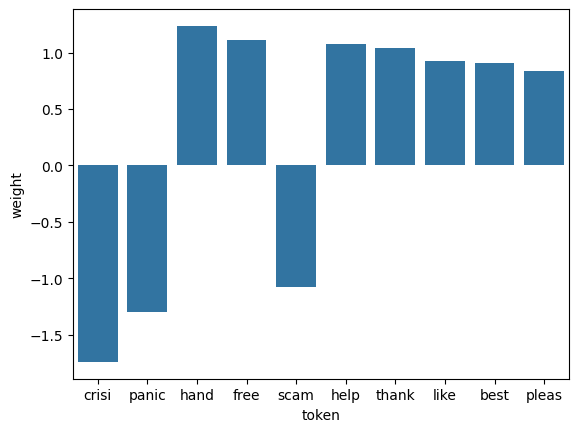

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=tokens, x='token', y='weight')
plt.show()

**Ответ:** люди пишут вежливо, если пишут позитивный твит + есть явные слова маркеры позитива и негатива

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x.split()[-1] == 'Positive' else 0)
df.fillna('Unknown')

print(df['UserName'].nunique(), len(df))
print(df['ScreenName'].nunique(), len(df))


33444 33444
33444 33444


**Ответ:** Все значения у рассматриваемых признаков уникальны. Сколько объектов - столько значений. Так что сами по себе эти признаки никак не помогут

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
print(len(df[df['Sentiment'] == 1]), len(df[df['Sentiment'] == 0]))

18046 15398


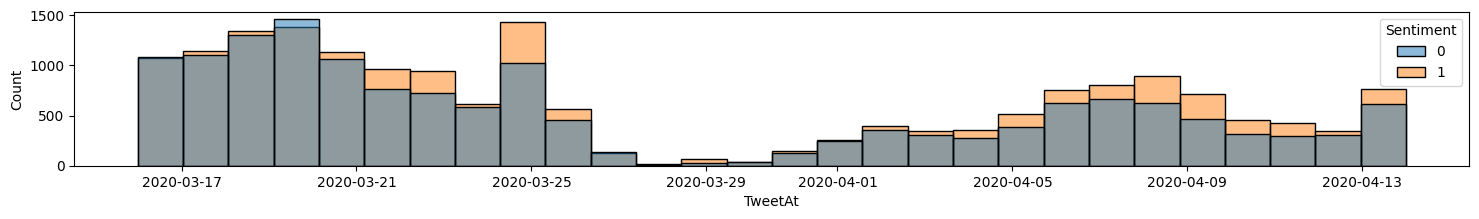

In [ ]:
import datetime as dt

df['TweetAt'] = df['TweetAt'].apply(lambda x: dt.datetime.strptime(x, '%d-%m-%Y'))
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
plt.figure(figsize=(18, 2))
sns.histplot(df, x='TweetAt', hue='Sentiment')
plt.show()

In [ ]:
data_df = pd.get_dummies(df['TweetAt'], drop_first=True)
x_data, x_test_data = data_df[:len(x_train)], data_df[len(x_train):]
x_test_data = x_test_data.reset_index()
x_test_data.drop('index', axis=1, inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_data = pd.DataFrame(sc.fit_transform(x_data))
x_test_data = pd.DataFrame(sc.transform(x_test_data))



In [ ]:
x_train_cv_df = pd.DataFrame(x_train_cv)
x_train_with_data = pd.concat([x_train_cv_df, x_data], axis=1)
x_train_with_data.columns = x_train_with_data.columns.astype(str)
x_test_cv_df = pd.DataFrame(x_test_cv)
x_test_with_data = pd.concat([x_test_cv_df, x_test_data], axis=1)
x_test_with_data.columns = x_test_with_data.columns.astype(str)

In [ ]:
LR = LogisticRegression()
LR.fit(x_train_with_data, y_train)
y_test_cv = LR.predict(x_test_with_data)

print(accuracy_score(y_test_cv, y_test))

0.8439306358381503


**Ответ:** В некоторые дни позитивных твитов чуть больше, чем негативных. Добавляем как призак => качество не меняется


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
df['Location'].nunique()

10465

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<ipython-input-131-10a2acc10e49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locs[df_locs['Location'] == 'Unknown']['count'] = 0


<Axes: xlabel='Location', ylabel='count'>

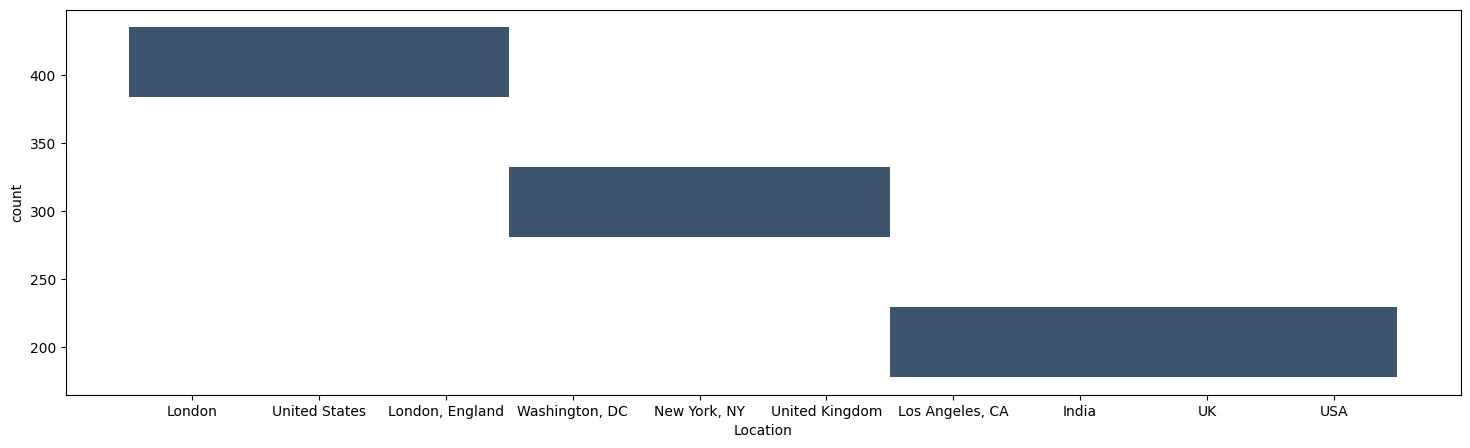

In [ ]:
df_locs = df['Location'].value_counts().reset_index()
df_locs[df_locs['Location'] == 'Unknown']['count'] = 0
df_locs_to_show = df_locs.sort_values(by='count', ascending=False)[:10]

plt.figure(figsize=(18, 5))
sns.histplot(data=df_locs_to_show, x = df_locs_to_show['Location'], y=df_locs_to_show['count'])

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

4200


<ipython-input-132-d356a92e26d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locs[df_locs['WiderLocation'] == 'Unknown']['count'] = 0


<Axes: xlabel='WiderLocation', ylabel='count'>

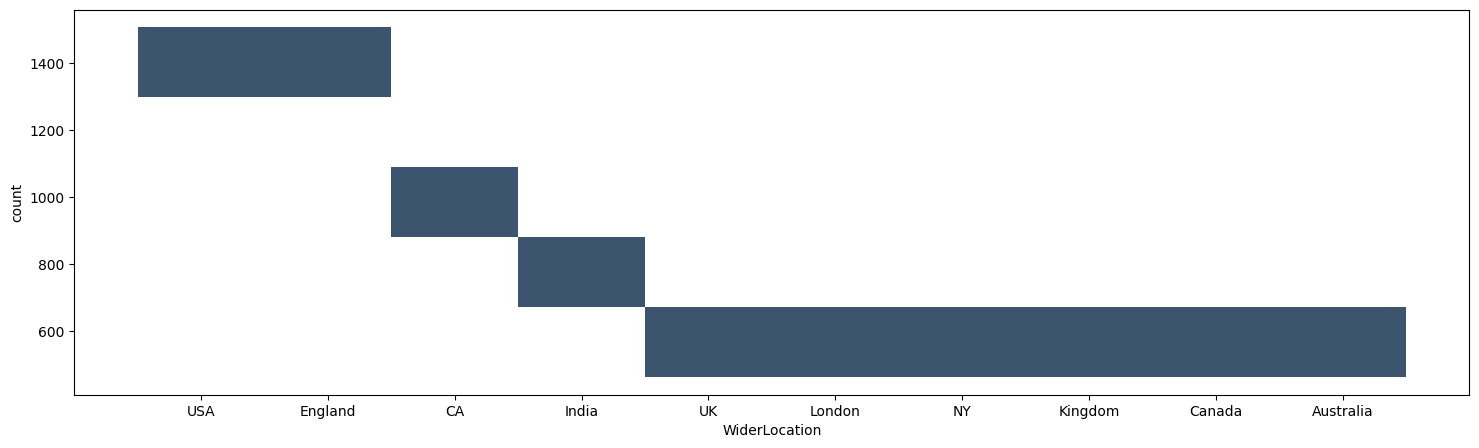

In [ ]:
df['WiderLocation'] = df['Location'].apply(lambda x: str(x).split()[-1] if len(str(x).split()) > 1 else str(x))
df_locs = df['WiderLocation'].value_counts().reset_index()
df_locs[df_locs['WiderLocation'] == 'Unknown']['count'] = 0
df_locs.drop(0, axis=0, inplace=True)
print(df_locs['WiderLocation'].nunique())
df_locs_to_show = df_locs.sort_values(by='count', ascending=False)[:10]

plt.figure(figsize=(18, 5))
sns.histplot(data=df_locs_to_show, x = df_locs_to_show['WiderLocation'], y=df_locs_to_show['count'])

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
df_locs = df_locs[df_locs['count'] > 1]
df_locs_list = df_locs['WiderLocation'].to_list()
print(len(df_locs_list))

1261


In [ ]:
# Идея в том, чтобы каждой локации из df_locs дать уникальный код, остальным локациям (которые по сути встречаются один раз) - дать другой
df['WLcode'] = df['WiderLocation'].apply(lambda x: df_locs_list.index(x) if x in df_locs_list else 9999)
loc_df = pd.get_dummies(df['WLcode'], drop_first=True)
loc_df_train, loc_df_train_test = loc_df[:len(x_train)], loc_df[len(x_train):]
loc_df_train_test = loc_df_train_test.reset_index()
loc_df_train_test.drop('index', axis=1, inplace=True)

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

loc_df_train = pd.DataFrame(sc.fit_transform(loc_df_train))
loc_df_train_test = pd.DataFrame(sc.transform(loc_df_train_test))

In [ ]:
x_train_cv_df = pd.DataFrame(x_train_cv)
x_train_with_data = pd.concat([x_train_cv_df, loc_df_train], axis=1)
x_train_with_data.columns = x_train_with_data.columns.astype(str)


In [ ]:
x_test_cv_df = pd.DataFrame(x_test_cv)
x_test_with_data = pd.concat([x_test_cv_df, loc_df_train_test], axis=1)
x_test_with_data.columns = x_test_with_data.columns.astype(str)

In [ ]:
LR = LogisticRegression()
LR.fit(x_train_with_data, y_train)
y_train_cv = LR.predict(x_train_with_data)
y_test_cv = LR.predict(x_test_with_data)

print(accuracy_score(y_train_cv, y_train))
print(accuracy_score(y_test_cv, y_test))

0.9578812473302007
0.8190153478174208


**Ответ:**  Качество на новых данных даже ухудшилось, локация нам не нужна